In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error , r2_score
import joblib
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/ishananda/Downloads/wind_dataset.csv')
data.rename(columns = {'LV ActivePower (kW)':'ActivePower(kW)',
                       "Wind Speed (m/s)":"WindSpeed(m/s)",
                       "Wind Direction (°)":"WindDirection","Theoretical_Power_Curve (KWh)":"TheoreticalPowerCurve(KWh)"},
            inplace = True)
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
data.shape

(50530, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date/Time                   50530 non-null  object 
 1   ActivePower(kW)             50530 non-null  float64
 2   WindSpeed(m/s)              50530 non-null  float64
 3   TheoreticalPowerCurve(KWh)  50530 non-null  float64
 4   WindDirection               50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [5]:
data.isnull().any()

Date/Time                     False
ActivePower(kW)               False
WindSpeed(m/s)                False
TheoreticalPowerCurve(KWh)    False
WindDirection                 False
dtype: bool

In [6]:
data.describe()

,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


# Visualizations

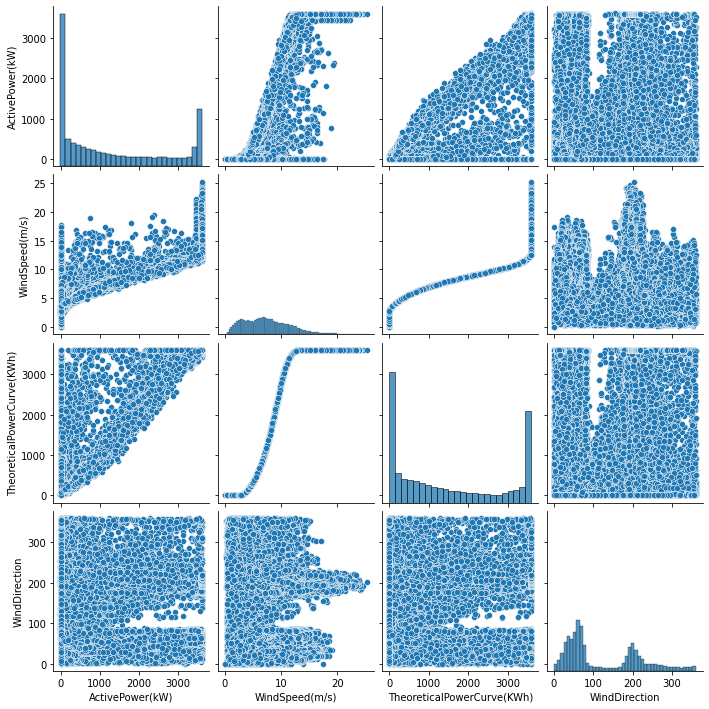

In [7]:
sns.pairplot(data);

/var/folders/rl/5gpt9xwn7tvblpdgg21zvszm0000gn/T/ipykernel_17871/2780765753.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


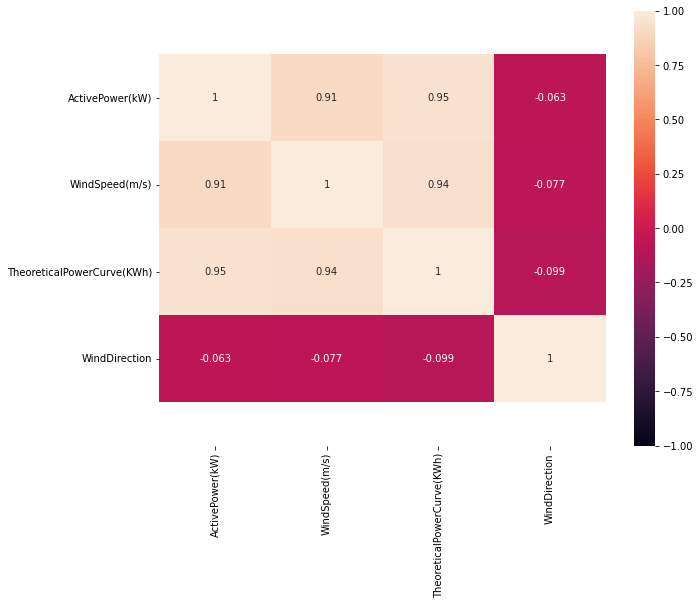

,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection
ActivePower(kW),1.000000,0.912774,0.949918,-0.062702
WindSpeed(m/s),0.912774,1.000000,0.944209,-0.077188
TheoreticalPowerCurve(KWh),0.949918,0.944209,1.000000,-0.099076
WindDirection,-0.062702,-0.077188,-0.099076,1.000000


In [8]:
corr = data.corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [9]:
! pip install windrose

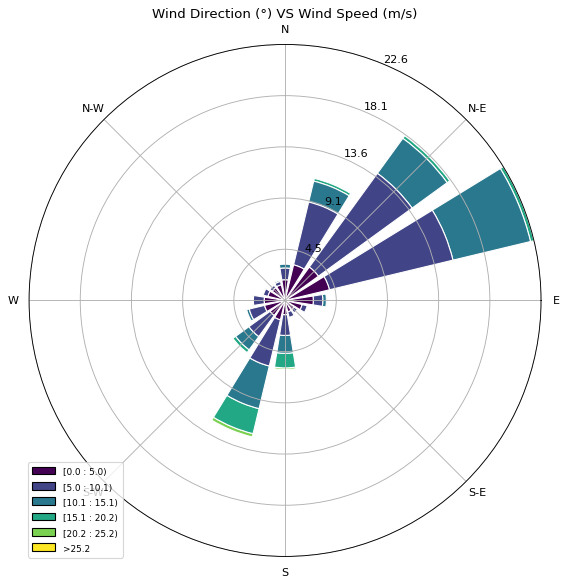

In [10]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(data['WindDirection'], data['WindSpeed(m/s)'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("Wind Direction (°) VS Wind Speed (m/s)")
plt.show()

# Data Preprocessing

In [11]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format='%d %m %Y %H:%M')
data['year'] = data['Date/Time'].dt.year 
data['month'] = data['Date/Time'].dt.month 
data['day'] = data['Date/Time'].dt.day
data['Hour'] = data['Date/Time'].dt.hour 
data['minute'] = data['Date/Time'].dt.minute 
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087,2018,1,1,0,30
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40


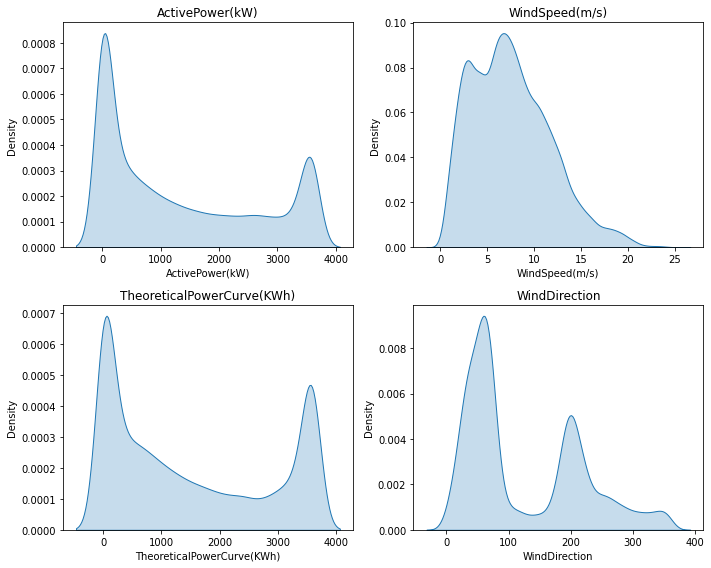

In [12]:
#plotting the data distribution
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data.iloc[:,i+1], shade=True)
    plt.title(data.columns[i+1])
plt.tight_layout()
plt.show()

In [13]:
#Converting the Data/Time feature in proper DateTime format
data["Date/Time"] = pd.to_datetime(data["Date/Time"], format = "%d %m %Y %H:%M", errors = "coerce")
data

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh),WindDirection,year,month,day,Hour,minute
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087,2018,1,1,0,30
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40
...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40


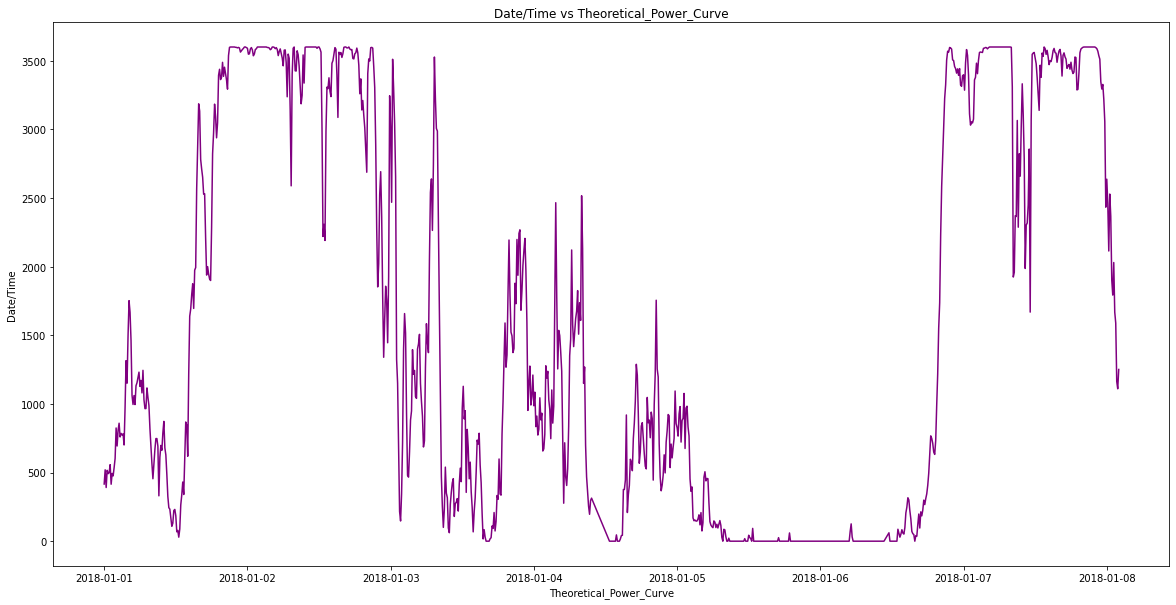

In [14]:
#Line Graph of DateTime VS Target variable
fig, ax = plt.subplots(figsize=(20,10))

# Add x-axis and y-axis
ax.plot(data['Date/Time'][0:1000],
        data['TheoreticalPowerCurve(KWh)'][0:1000],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Theoretical_Power_Curve",
       ylabel="Date/Time",
       title="Date/Time vs Theoretical_Power_Curve")

plt.show()

In [15]:
# Droping all the irrelavent features that dosent affect the target variable.
cols = ["WindDirection", 'year', 'month', "day", "Hour", "minute" ]
data = data.drop(cols, axis=1)
data.head()

,Date/Time,ActivePower(kW),WindSpeed(m/s),TheoreticalPowerCurve(KWh)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972
